# FMCA Samplet GP Filtering

We can use samplets for kernel filtering, that is we represent the kernel in a samplet basis and pick the diagonal subblock containing the largest diagonal elements. This way, we can even deal with highly ill conditioned kernels
and arbitrary data sizes.

### first import modules

In [1]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import scipy
import scipy.sparse.linalg as sla
import time
import FMCA

### Create data points
(We force NumPy to use column major arrays for performance reasons)

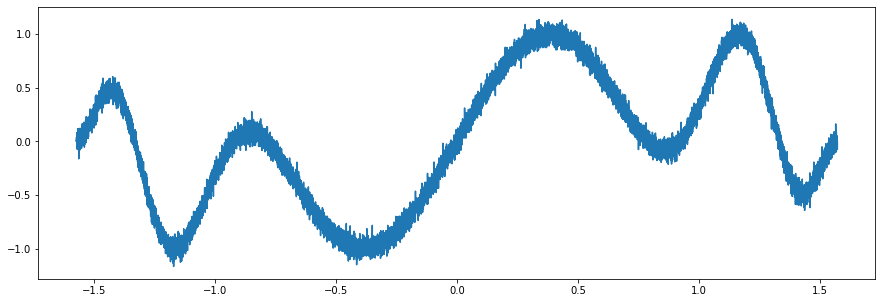

In [2]:
dim = 1
N = 20000
pts = np.pi * (np.array(np.sort(np.random.rand(dim, N)), order='F') - 0.5)
y = np.sin(4 * pts) * np.cos(2 * pts**3) + 0.05 * np.random.randn(1, N)
plt.figure(figsize=(15,5))
plt.plot(pts[0,:], y[0,:])
plt.show()

## create samplet compressed kernel matrix
We use here a Gaussian kernel

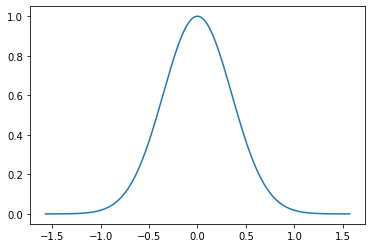

time tree setup:              0.07927894592285156 sec.
mpole deg:                    10
dtilde:                       10
eta:                          0.8
thres:                        1e-06
anz:                          1
compression error:            1.67839e-07
time kernel compression:      0.43031787872314453 sec.


In [3]:
dtilde = 10
cov = FMCA.CovarianceKernel("GAUSSIAN", 0.25)
plt.plot(pts[0,:], cov.eval(np.array([0.], order='F'), pts)[0,:])
plt.show()
start = time.time()
ST = FMCA.SampletTree(pts, dtilde)
stop = time.time()
print('time tree setup:             ', stop - start, 'sec.')
start = time.time()
SKC = FMCA.SampletKernelCompressor(ST, cov, pts, 0.8, 1e-6)
stop = time.time()
print('time kernel compression:     ', stop - start, 'sec.')
# return matrix and create lower triangular part
K = SKC.matrix()
K = K + scipy.sparse.triu(K, k=1).transpose()

## filter the kernel matrix
in Samplet basis, we now filter the relevant frequencies by simple diagonal pivoting (!!!) the remaining number of coefficients is steered by the parameter number_of_coefficients

filtered kernel error:        0.00013853881680186156
condition number:             26760037.28835028


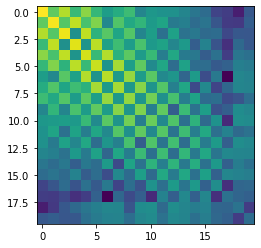

In [7]:
number_of_coefficients = 20
idx = np.sort((-K.diagonal()).argsort()[:number_of_coefficients])
Ksmall = K[np.ix_(idx,idx)]
Kemb = scipy.sparse.csr_matrix((N,N))
Kemb[np.ix_(idx,idx)] = Ksmall
print('filtered kernel error:       ', sla.norm(K-Kemb)/sla.norm(K))
print('condition number:            ', la.cond(Ksmall.todense()))
plt.imshow(np.log(np.abs(Ksmall.todense())+1e-16))
plt.show()

## now filter data and solve the linear system

In [8]:
Ty = FMCA.sampletTransform(ST, y.transpose())
Tysmall = Ty[idx,:];
Talpha = la.solve(Ksmall.todense(), Tysmall)
r = Tysmall - Ksmall @ Talpha
print('residual:                    ', la.norm(r)/la.norm(Tysmall))
Talphaemb = np.zeros(Ty.shape)
Talphaemb[idx,:] = Talpha
alpha = FMCA.inverseSampletTransform(ST, Talphaemb)

residual:                     1.1721524806368294e-13


## evaluate kernel interpolant

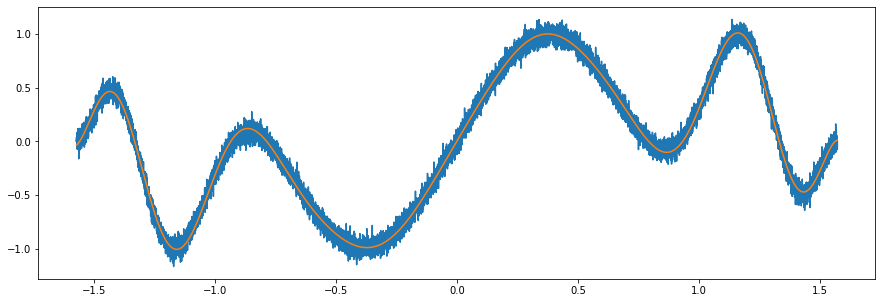

residual:                     0.08730732699614951


In [9]:
Keval = cov.eval(pts, pts)
r = y.transpose() - Keval @ alpha
plt.figure(figsize=(15,5))
plt.plot(pts[0,:], y[0,:])
plt.plot(pts[0,:], (Keval @ alpha)[:,0])
plt.show()
print('residual:                    ', la.norm(r)/la.norm(y))